# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [19]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 40
num_epochs = 20

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size,image_x,image_y):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Number of Images need to consider 
    img_idx = np.arange(1,30,2) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(folder_list))//batch_size # calculate the number of batches
        pending_Data = (len(folder_list)) - (num_batches * batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_x,image_y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image,(image_x,image_y)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100
                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        # write the code for the remaining data points which are left after full batches
        if(pending_Data > 0):
            batch_data = np.zeros((batch_size,len(img_idx),image_x,image_y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))
            for folder in range(pending_Data):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image,(image_x,image_y)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100
                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [1]:
# Model creation factory

class ModelFactory:
    def __init__(self,batch_size=40,epochs=50,image_x =100,image_y =100,num_classes=5):
        self.batch_size=batch_size
        self.epochs=epochs
        self.image_x=image_x
        self.image_y=image_y
        self.num_classes=num_classes
        self.input_shape = np.zeros((batch_size,len(np.arange(1,30,2)),self.image_x,self.image_y,3)).shape[1:]
       
        
    def conv3Dseq_1(self):
        model = Sequential()
        model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=self.input_shape,activation='relu')) 
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        return model

    def conv3Dseq_2(self):
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=self.input_shape,activation='relu'))        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(.5))


        model.add(Dense(self.num_classes,activation='softmax'))

        return model

    
    def conv3Dseq_3(self):
        model = Sequential()
        model.add(Conv3D(32, (2, 2, 2), padding='same', input_shape=self.input_shape,activation='relu'))        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(.5))


        model.add(Dense(self.num_classes,activation='softmax'))

        return model
    
    
    
    def conv2d_LSTM(self):
    
        model = Sequential()

        model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2),
                    activation='relu', padding='same'), input_shape=self.input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(128))
        model.add(Dropout(.25))
        
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(.25))
        
        model.add(Dense(self.num_classes, activation='softmax'))

        return model
    
    def conv2d_GRU(self):
    
        model = Sequential()

        model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2),
                    activation='relu', padding='same'), input_shape=self.input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(128))
        model.add(Dropout(.25))
        
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(.25))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        return model
    
    def Resnet_CNN_LSTM():
        resnet = ResNet50(include_top=False, weights='imagenet', pooling = 'avg')
        input_layer = Input(shape=self.input_shape)
        curr_layer = TimeDistributed(resnet)(input_layer)
        #curr_layer = Dropout(0.25)(curr_layer)
        curr_layer = Reshape(target_shape=(self.input_shape, 2048))(curr_layer)
        lstm_out = LSTM(256, dropout=0.25)(curr_layer)
        output = Dense(output_dim=self.num_classes, activation='softmax')(lstm_out)
        model = Model([input_layer], output)
        return model

    def Resnet_CNN_GRU():
        resnet = ResNet50(include_top=False, weights='imagenet', pooling = 'avg')
        input_layer = Input(shape=self.input_shape)
        curr_layer = TimeDistributed(resnet)(input_layer)
        #curr_layer = Dropout(0.25)(curr_layer)
        curr_layer = Reshape(target_shape=(self.input_shape, 2048))(curr_layer)
        gru_out = GRU(256, dropout=0.25)(curr_layer)
        output = Dense(output_dim=self.num_classes, activation='softmax')(gru_out)
        model = Model([input_layer], output)
        return model
    
    def Vgg_CNN_LSTM():
        vggNet = vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')
        input_layer = Input(shape=self.input_shape)
        curr_layer = TimeDistributed(vggNet)(input_layer)
        #curr_layer = Dropout(0.25)(curr_layer)
        curr_layer = Reshape(target_shape=(self.input_shape, 512))(curr_layer)
        gru_out = LSTM(256, dropout=0.25)(curr_layer)
        output = Dense(output_dim=self.num_classes, activation='softmax')(gru_out)
        model = Model([input_layer], output)
        return model

    def initModel(self,modelName):
        if modelName == 'conv3DSeq_1':
            model = self.conv3Dseq_1()
        elif modelName == 'conv3DSeq_2':
            model = self.conv3Dseq_2()
        elif modelName == 'conv3DSeq_3':
            model = self.conv3Dseq_3()  
        elif modelName == 'conv2d_LSTM':
            model = self.conv2d_LSTM()      
        elif modelName == 'conv2d_LSTM':
            model = self.conv2d_LSTM()       
        else:
            model = self.conv2d_GRU()
            
        self.model=model
        self.modelName=modelName
        return model, modelName
    
    def get_validation_step_per_epoch(self):
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1
        
        return steps_per_epoch,validation_steps
    
    
    def plot(self):
        print(self.history.history.keys())
        # summarize history for accuracy
        plt.plot(self.history.history['categorical_accuracy'])
        plt.plot(self.history.history['val_categorical_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    def getCallbackList(self):
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        # write the Reducelronplateau code here
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
        es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)
        # LR= DecayLR()
        return [es,checkpoint, LR]

    def execute(self,optimiser = 'SGD'):
        print('====================================='+self.modelName+'==============================================')
        train_generator = generator(train_path, train_doc, self.batch_size,self.image_x,self.image_y)
        val_generator = generator(val_path, val_doc,self.batch_size,self.image_x,self.image_y)
        steps_per_epoch,validation_steps = self.get_validation_step_per_epoch()
        #Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.
        self.model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        
        callbacks_list = self.getCallbackList()
        self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        self.plot()

## Model - 1

In [25]:
# optimiser = 'SGD'
model_factory=ModelFactory(batch_size=20,epochs=20)



=====================================conv3DSeq_1==============================================
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 15, 100, 100, 64)  5248      
                                                                 
 activation_16 (Activation)  (None, 15, 100, 100, 64)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 15, 100, 100, 64)  256      
 chNormalization)                                                
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 7, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_11 (Conv3D)          (None, 7, 50, 50, 32)     16416     
                         

/tmp/ipykernel_1061/2213664013.py:249: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1,


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7698 - categorical_accuracy: 0.3618Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2022-05-1619_14_49.083926/model-00001-1.76984-0.36176-1.89090-0.22500.h5
34/34 [==============================] - 36s 1s/step - loss: 1.7698 - categorical_accuracy: 0.3618 - val_loss: 1.8909 - val_categorical_accuracy: 0.2250 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3525 - categorical_accuracy: 0.4765
Epoch 00002: saving model to model_init_2022-05-1619_14_49.083926/model-00002-1.35245-0.47647-1.76478-0.25000.h5
34/34 [==============================] - 35s 1s/step - loss: 1.3525 - categorical_accuracy: 0.4765 - val_loss: 1.7648 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1258 - categorical_accuracy: 0.5647
Epoch 00003: saving model to model_init_2022-05-1619_14_49.

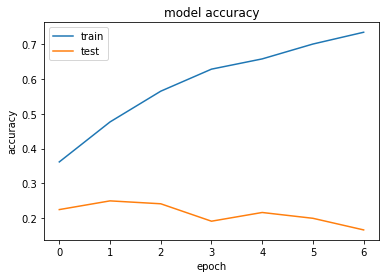

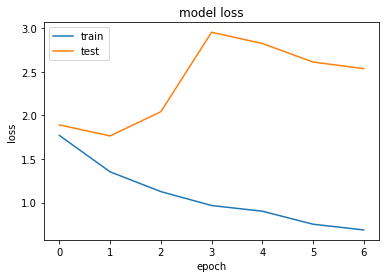

In [26]:
model_factory.initModel('conv3DSeq_1')
model_factory.execute()

### As we can see this model is clearly overfitting, let try changing the image size

## Model-2

=====================================conv3DSeq_1==============================================
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 15, 120, 120, 64)  5248      
                                                                 
 activation_28 (Activation)  (None, 15, 120, 120, 64)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 15, 120, 120, 64)  256      
 chNormalization)                                                
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 7, 60, 60, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_23 (Conv3D)          (None, 7, 60, 60, 32)     16416     
                         

/tmp/ipykernel_1061/3366159680.py:243: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1,


Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6275 - categorical_accuracy: 0.4279Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2022-05-1619_14_49.083926/model-00001-1.62746-0.42794-1.80329-0.20000.h5
34/34 [==============================] - 37s 1s/step - loss: 1.6275 - categorical_accuracy: 0.4279 - val_loss: 1.8033 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.0700 - categorical_accuracy: 0.5794
Epoch 00002: saving model to model_init_2022-05-1619_14_49.083926/model-00002-1.07000-0.57941-2.24402-0.13333.h5
34/34 [==============================] - 36s 1s/step - loss: 1.0700 - categorical_accuracy: 0.5794 - val_loss: 2.2440 - val_categorical_accuracy: 0.1333 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.7828 - categorical_accuracy: 0.6618
Epoch 00003: saving model to model_init_2022-05-1619_14_49.

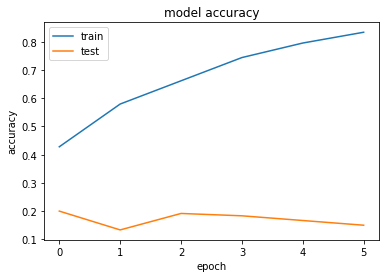

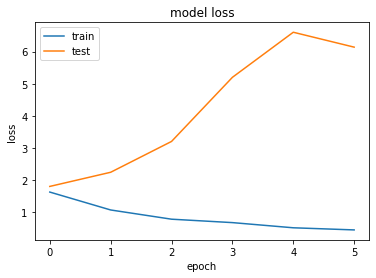

In [36]:
model_factory=ModelFactory(batch_size=20,epochs=10,image_x=120,image_y=120)

model_factory.initModel('conv3DSeq_1')
model_factory.execute(optimiser='adam')

### We can see not much impact, let try reducing the batch size , and increase the image size

## Model-3

In [32]:
model_factory=ModelFactory(batch_size=10,epochs=20,image_x=140,image_y=140)


=====================================conv3DSeq_1==============================================
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_19 (Conv3D)          (None, 15, 140, 140, 64)  5248      
                                                                 
 activation_25 (Activation)  (None, 15, 140, 140, 64)  0         
                                                                 
 batch_normalization_25 (Bat  (None, 15, 140, 140, 64)  256      
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 7, 70, 70, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_20 (Conv3D)          (None, 7, 70, 70, 32)     16416     
                         

/tmp/ipykernel_1061/2213664013.py:249: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.5499 - categorical_accuracy: 0.4254Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-05-1619_14_49.083926/model-00001-1.54994-0.42537-4.65371-0.18182.h5
67/67 [==============================] - 41s 589ms/step - loss: 1.5499 - categorical_accuracy: 0.4254 - val_loss: 4.6537 - val_categorical_accuracy: 0.1818 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1830 - categorical_accuracy: 0.5522
Epoch 00002: saving model to model_init_2022-05-1619_14_49.083926/model-00002-1.18298-0.55224-12.99290-0.20000.h5
67/67 [==============================] - 39s 583ms/step - loss: 1.1830 - categorical_accuracy: 0.5522 - val_loss: 12.9929 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9531 - categorical_accuracy: 0.6209
Epoch 00003: saving model to model_init_2022-05-161

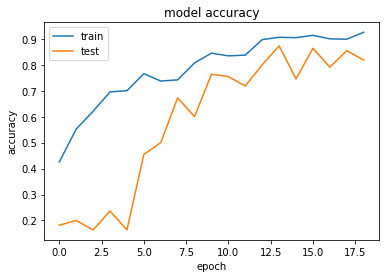

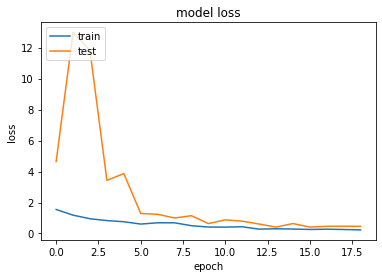

In [33]:
model_factory.initModel('conv3DSeq_1')
model_factory.execute(optimiser='adam')


### As we see from the above experiments image resolution have more impact on training time than batch_size

### Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

### Try changing the filter size

## Model-4

=====================================conv3DSeq_2==============================================
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_35 (Conv3D)          (None, 15, 140, 140, 32)  2624      
                                                                 
 activation_41 (Activation)  (None, 15, 140, 140, 32)  0         
                                                                 
 batch_normalization_46 (Bat  (None, 15, 140, 140, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 7, 70, 70, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_36 (Conv3D)          (None, 7, 70, 70, 64)     55360     
                        

/tmp/ipykernel_1061/1877824852.py:238: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1,


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 2.1776 - categorical_accuracy: 0.2955Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-05-1619_14_49.083926/model-00001-2.17755-0.29552-16.76043-0.26364.h5
67/67 [==============================] - 40s 576ms/step - loss: 2.1776 - categorical_accuracy: 0.2955 - val_loss: 16.7604 - val_categorical_accuracy: 0.2636 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.5966 - categorical_accuracy: 0.4269
Epoch 00002: saving model to model_init_2022-05-1619_14_49.083926/model-00002-1.59657-0.42687-29.00973-0.26364.h5
67/67 [==============================] - 38s 570ms/step - loss: 1.5966 - categorical_accuracy: 0.4269 - val_loss: 29.0097 - val_categorical_accuracy: 0.2636 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.3691 - categorical_accuracy: 0.4836
Epoch 00003: saving model to model_init_2022-05-1

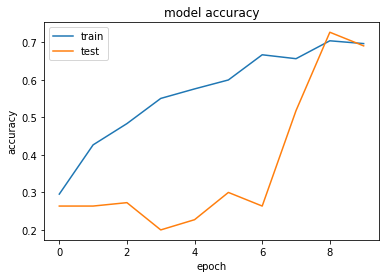

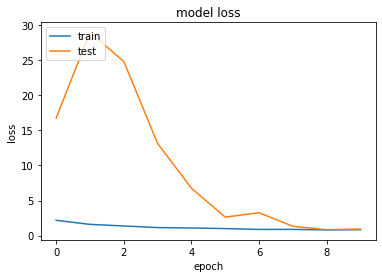

In [44]:
model_factory=ModelFactory(batch_size=10,epochs=10,image_x=140,image_y=140)
model_factory.initModel('conv3DSeq_2')
model_factory.execute('adam')

### Accuracy didn't improve, lets reduce the filter size

## Model-5


=====================================conv3DSeq_3==============================================
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_38 (Conv3D)          (None, 15, 140, 140, 32)  800       
                                                                 
 activation_44 (Activation)  (None, 15, 140, 140, 32)  0         
                                                                 
 batch_normalization_51 (Bat  (None, 15, 140, 140, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_35 (MaxPoolin  (None, 7, 70, 70, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_39 (Conv3D)          (None, 7, 70, 70, 64)     16448     
                        

/tmp/ipykernel_1061/4024775974.py:237: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.8811 - categorical_accuracy: 0.3493Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-05-1619_14_49.083926/model-00001-1.88105-0.34925-6.42931-0.16364.h5
67/67 [==============================] - 39s 572ms/step - loss: 1.8811 - categorical_accuracy: 0.3493 - val_loss: 6.4293 - val_categorical_accuracy: 0.1636 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.5156 - categorical_accuracy: 0.4433
Epoch 00002: saving model to model_init_2022-05-1619_14_49.083926/model-00002-1.51558-0.44328-15.90905-0.16364.h5
67/67 [==============================] - 38s 574ms/step - loss: 1.5156 - categorical_accuracy: 0.4433 - val_loss: 15.9090 - val_categorical_accuracy: 0.1636 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.2156 - categorical_accuracy: 0.5433
Epoch 00003: saving model to model_init_2022-05-161

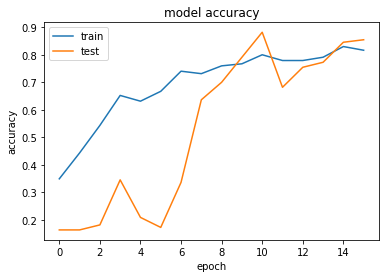

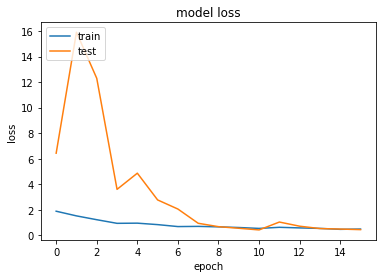

In [47]:
model_factory=ModelFactory(batch_size=10,epochs=20,image_x=140,image_y=140)
model_factory.initModel('conv3DSeq_3')
model_factory.execute('adam')

### Model has a best validation accuracy of 84% and training accuracy of 82% . Also we were able to reduce the parameter size by half the earlier model.

### Lets try LSTM and GRU

## Model-6


=====================================conv2d_LSTM==============================================
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 70, 70, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 70, 70, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 35, 35, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 35, 35, 32)   9248      
 stributed)                                                      
                        

/tmp/ipykernel_1061/3764336217.py:246: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.3760 - categorical_accuracy: 0.4060Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-05-1619_14_49.083926/model-00001-1.37597-0.40597-1.88740-0.11818.h5
67/67 [==============================] - 41s 570ms/step - loss: 1.3760 - categorical_accuracy: 0.4060 - val_loss: 1.8874 - val_categorical_accuracy: 0.1182 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0052 - categorical_accuracy: 0.6358
Epoch 00002: saving model to model_init_2022-05-1619_14_49.083926/model-00002-1.00521-0.63582-1.56441-0.30909.h5
67/67 [==============================] - 37s 567ms/step - loss: 1.0052 - categorical_accuracy: 0.6358 - val_loss: 1.5644 - val_categorical_accuracy: 0.3091 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8884 - categorical_accuracy: 0.6552
Epoch 00003: saving model to model_init_2022-05-1619_

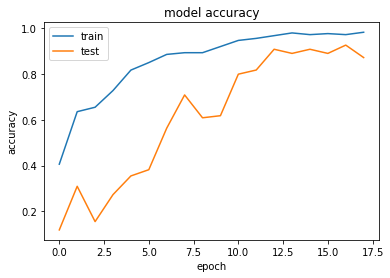

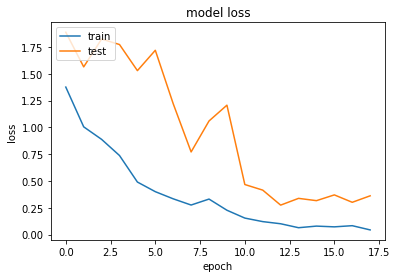

In [52]:
model_factory=ModelFactory(batch_size=10,epochs=20,image_x=140,image_y=140)
model_factory.initModel('conv2d_LSTM')
model_factory.execute('adam')

### With LSTM Model has a best validation accuracy of 92% and training accuracy of 97% . Let's try GRU

## Model-7

=====================================conv2d_LSTM==============================================
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 15, 70, 70, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 15, 70, 70, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 15, 35, 35, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 15, 35, 35, 32)   9248      
 stributed)                                                      
                        

/tmp/ipykernel_1061/1005849177.py:255: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.3723 - categorical_accuracy: 0.4119Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-05-1619_14_49.083926/model-00001-1.37228-0.41194-1.63585-0.24545.h5
67/67 [==============================] - 45s 648ms/step - loss: 1.3723 - categorical_accuracy: 0.4119 - val_loss: 1.6359 - val_categorical_accuracy: 0.2455 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0343 - categorical_accuracy: 0.5866
Epoch 00002: saving model to model_init_2022-05-1619_14_49.083926/model-00002-1.03425-0.58657-1.66346-0.29091.h5
67/67 [==============================] - 42s 637ms/step - loss: 1.0343 - categorical_accuracy: 0.5866 - val_loss: 1.6635 - val_categorical_accuracy: 0.2909 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8709 - categorical_accuracy: 0.6597
Epoch 00003: saving model to model_init_2022-05-1619_

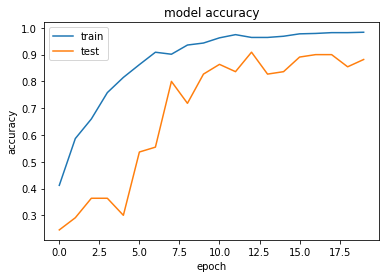

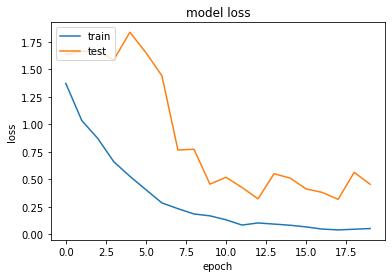

In [55]:
model_factory=ModelFactory(batch_size=10,epochs=20,image_x=140,image_y=140)
model_factory.initModel('conv2d_LSTM')
model_factory.execute('adam')

### With GRU Model has a best validation accuracy of 90% and training accuracy of 99% . Let's try transfer learning

## Transfer Learning + LSTM/GRU (ResNet/VGGnet)

## Model-8

2022-05-16 22:03:28.338086: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-16 22:03:28.338144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


=====================================Resnet_CNN_LSTM==============================================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 70, 70, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 70, 70, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 35, 35, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 35, 35, 32)   9248      
 tributed)                                                       
                       

/tmp/ipykernel_373/3328927404.py:288: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1,


Epoch 1/20


2022-05-16 22:03:31.844890: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.3734 - categorical_accuracy: 0.4403Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-05-1621_56_03.724027/model-00001-1.37345-0.44030-2.41124-0.17273.h5
67/67 [==============================] - 41s 551ms/step - loss: 1.3734 - categorical_accuracy: 0.4403 - val_loss: 2.4112 - val_categorical_accuracy: 0.1727 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0140 - categorical_accuracy: 0.6075
Epoch 00002: saving model to model_init_2022-05-1621_56_03.724027/model-00002-1.01404-0.60746-2.14704-0.19091.h5
67/67 [==============================] - 36s 542ms/step - loss: 1.0140 - categorical_accuracy: 0.6075 - val_loss: 2.1470 - val_categorical_accuracy: 0.1909 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8474 - categorical_accuracy: 0.6493
Epoch 00003: saving model to model_init_2022-05-1621_56_03.72402

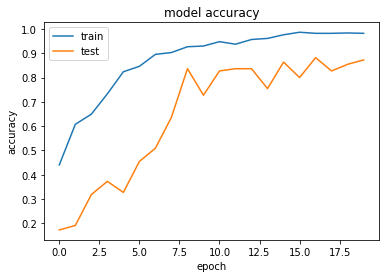

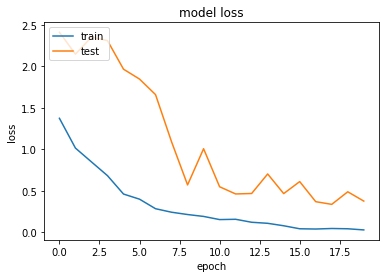

In [16]:
model_factory=ModelFactory(batch_size=10,epochs=20,image_x=140,image_y=140)
model_factory.initModel('Resnet_CNN_LSTM')
model_factory.execute('adam')

### With ResNet LSTM Model has a best validation accuracy of 88% and training accuracy of 98% .

## Model-9

=====================================Resnet_CNN_GRU==============================================
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 70, 70, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 70, 70, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 35, 35, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 35, 35, 32)   9248      
 stributed)                                                      
                      

/tmp/ipykernel_373/3328927404.py:288: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.3658 - categorical_accuracy: 0.4284Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-05-1621_56_03.724027/model-00001-1.36576-0.42836-1.75225-0.24545.h5
67/67 [==============================] - 38s 548ms/step - loss: 1.3658 - categorical_accuracy: 0.4284 - val_loss: 1.7523 - val_categorical_accuracy: 0.2455 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0111 - categorical_accuracy: 0.6224
Epoch 00002: saving model to model_init_2022-05-1621_56_03.724027/model-00002-1.01108-0.62239-1.63643-0.23636.h5
67/67 [==============================] - 36s 544ms/step - loss: 1.0111 - categorical_accuracy: 0.6224 - val_loss: 1.6364 - val_categorical_accuracy: 0.2364 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8443 - categorical_accuracy: 0.6627
Epoch 00003: saving model to model_init_2022-05-1621_

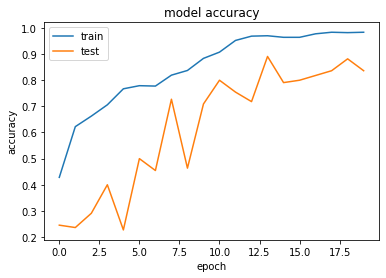

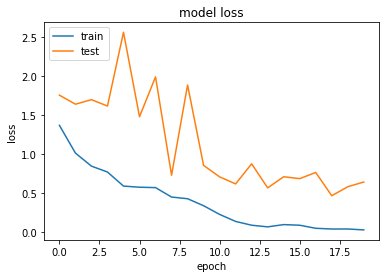

In [17]:
model_factory=ModelFactory(batch_size=10,epochs=20,image_x=140,image_y=140)
model_factory.initModel('Resnet_CNN_GRU')
model_factory.execute('adam')

### With ResNet GRU Model has a best validation accuracy of 89% and training accuracy of 97% .

## Model-10

=====================================Vgg_CNN_LSTM==============================================
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 15, 70, 70, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 15, 70, 70, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 15, 35, 35, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 15, 35, 35, 32)   9248      
 stributed)                                                      
                        

/tmp/ipykernel_373/3328927404.py:288: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.3951 - categorical_accuracy: 0.3910Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-05-1621_56_03.724027/model-00001-1.39513-0.39104-2.33408-0.18182.h5
67/67 [==============================] - 38s 545ms/step - loss: 1.3951 - categorical_accuracy: 0.3910 - val_loss: 2.3341 - val_categorical_accuracy: 0.1818 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.9700 - categorical_accuracy: 0.6224
Epoch 00002: saving model to model_init_2022-05-1621_56_03.724027/model-00002-0.97002-0.62239-1.90774-0.30000.h5
67/67 [==============================] - 36s 550ms/step - loss: 0.9700 - categorical_accuracy: 0.6224 - val_loss: 1.9077 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8665 - categorical_accuracy: 0.6493
Epoch 00003: saving model to model_init_2022-05-1621_

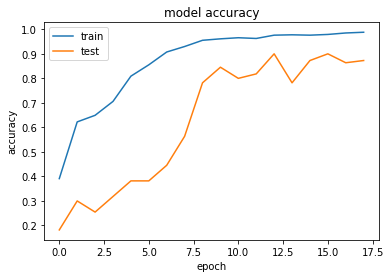

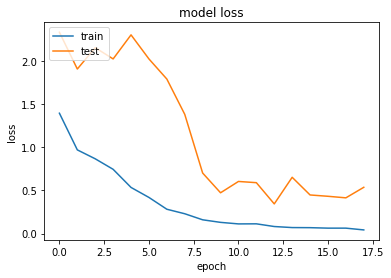

In [18]:
model_factory=ModelFactory(batch_size=10,epochs=20,image_x=140,image_y=140)
model_factory.initModel('Vgg_CNN_LSTM')
model_factory.execute('adam')

### With VGGNet LSTM Model has a best validation accuracy of 90% and training accuracy of 97% . 